

```
Overview

*   Get an under powered car to the top of a hill (top = 0.5 in position)
*   Car starts at random position from -0.6 to -0.4 with no velocity
*   -1 towards reward for each time step, until the car reaches the goal position
*   There are two states (position and velocity) and three actions (left, none, or right).
```



In [1]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
from keras import Sequential, models
from keras.layers import Dense
from keras.optimizers import adam
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Construct agent

In [0]:
class DQN():

    """ Implementation of deep q learning algorithm"""

    def __init__(self):

        """
        Initalize an Agent object
        """

        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.epsilon = 1
        self.epsilon_min = .001
        self.epsilon_decay = .999
        self.discount_factor = 0.9
        self.learning_rate = 0.001
        self.batch_size = 128
        self.memory = deque(maxlen = 10000)
        self.model = self.build_model()

    def build_model(self):

        """
        The model is a convolutional neural network. It is trying to predict 
        the return of taking each action given the current state of the environment.
        """

        model = Sequential()
        model.add(Dense(24, input_shape = (self.state_space,), activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_space, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = adam(lr = self.learning_rate))
        return model

    def save_model(self, filename = None):

        self.model.save(filename)

    def remember(self, state, action, reward, next_state, done):

        """
        Save the memory that the agent observes and we will use this data later
        """ 

        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        """
        To balance between exploration and exploitation, a epsilon-greedy policy is introduced.
        It is a decaying probability percentage which the learning algorithm uses to choose between. 
        picking random action (exploration) or greedy action based on existing knowledge (exploitation).
        """

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        if random.uniform(0, 1) <= self.epsilon: # exploration
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state) # exploitation
            return np.argmax(act_values[0])

    def replay(self):
        
        """
        Agent experiences replay memory during training. Replay memory will be selected randomly,
        so that a batch of tranining samples are decorrelted. 
        """
      
        # Wait until we have enough sample available in memeory
        if len(self.memory) < self.batch_size: 
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Q function is updated based on Bellman Equation
        states, next_states = np.squeeze(states), np.squeeze(next_states)
        targets = rewards + self.discount_factor * (np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets 

        self.model.fit(states, targets_full, epochs = 1, verbose = 0)

    def total_energy(self, state):
        """
        Total energy is the sum of its motion (i.e., kinetic energy) and/or the result of its stored energy of position (i.e., potential energy).
        """
        x = state[0, 0] # position in x direction
        v = state[0, 1] # velocity

        # A change of the height is given by dh = dx cos φx, 
        # which integrates to hx = 0.0025 / g * cos(3x)dx = 0.0025 / (3g) * sin(3x) + C
        # Here we will use g = 1, and C = 0
        potential_energy = 0.0025 / 3 * (math.sin(3 * x)) 
        kinetic_energy = 0.5 * (v ** 2)

        return potential_energy + kinetic_energy

Train agent

In [3]:
def train_dqn(episode):
    """
    Train dqn model to interact with and learn from the environment
    """
    loss = []
    agent = DQN() 
    goal = 0.5
  
    for e in range(episode):
        env.seed(episode)
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 1000

        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, 2))
            score = score -1
            reward = 1000 * (agent.total_energy(next_state) - agent.total_energy(state)) 
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            # Typically the episode is done when the agent reaches the goal or 200 steps.
            # Because it take a lot of tries before the car can get out the bottom of the velly,
            # here we will terminate the episode when the agent reach max steps or the goal
            if state[0,0] >= goal: 
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        env.close()
        loss.append(score)
        if np.average(loss[-10:]) >= -110:
            break
    agent.save_model(filename = 'MountainCar-v0-dqn.h5')
    return loss

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ep = 75
    loss = train_dqn(ep)

episode: 0/75, score: -531
episode: 1/75, score: -265
episode: 2/75, score: -199
episode: 3/75, score: -201
episode: 4/75, score: -131
episode: 5/75, score: -118
episode: 6/75, score: -123
episode: 7/75, score: -127
episode: 8/75, score: -124
episode: 9/75, score: -119
episode: 10/75, score: -119
episode: 11/75, score: -137
episode: 12/75, score: -118
episode: 13/75, score: -117
episode: 14/75, score: -122
episode: 15/75, score: -145
episode: 16/75, score: -129
episode: 17/75, score: -119
episode: 18/75, score: -162
episode: 19/75, score: -145
episode: 20/75, score: -112
episode: 21/75, score: -146
episode: 22/75, score: -115
episode: 23/75, score: -115
episode: 24/75, score: -118
episode: 25/75, score: -116
episode: 26/75, score: -111
episode: 27/75, score: -116
episode: 28/75, score: -115
episode: 29/75, score: -122
episode: 30/75, score: -112
episode: 31/75, score: -150
episode: 32/75, score: -113
episode: 33/75, score: -113
episode: 34/75, score: -111
episode: 35/75, score: -150
ep

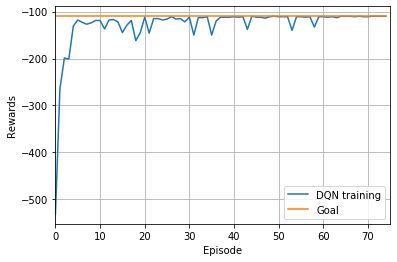

In [4]:
### Visualize the process of training dqn model
plt.subplots(figsize= (6, 4))
plt.plot(list(range(len(loss))), loss, label = 'DQN training')
plt.plot(list(range(len(loss))), np.ones((len(loss), 1))* -110, label = 'Goal')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.legend(loc = 'lower right')
plt.xlim(0, len(loss))
plt.grid(True)
plt.show()

Test

In [5]:
def test_dqn(episode):

    """
    Valide dqn model with 100 trials
    """
  
    episodes = episode
    scores = []

    for e in range(episodes):
        state = env.reset()
        score = 0
        while True:
            action = np.argmax(model.predict(np.array([state])))
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                scores.append(score)
                break
        env.close()
    return np.average(scores)

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    model = models.load_model('MountainCar-v0-dqn.h5')
    ep = 100
    loss = test_dqn(ep)
    print('Average rewards in the last 100 episodes: {}'.format(loss))

Average rewards in the last 100 episodes: -109.6
